In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%config Completer.use_jedi = False  # 자동완성 속도 증가
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from keras import layers

Using TensorFlow backend.


In [2]:
# 보스턴 주택 데이터셋 로드
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = (
    boston_housing.load_data())

In [3]:
# 데이터 정규화 (테스트 데이터는 정규화에 사용하지 말 것)
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [4]:
# 모델 정의 (스칼라 회귀를 위한 구성)
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1) # 활성화 함수 X
    ])
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

In [5]:
# k겹 검증
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f'#{i + 1}번째 폴드 처리중')
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중
#4번째 폴드 처리중


In [7]:
np.mean(all_scores)

2.3705992102622986

In [13]:
# 각 폴드의 검증 검수 저장
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f'#{i + 1}번째 폴드 처리중')
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                       validation_data=(val_data, val_targets),
                       epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중
#4번째 폴드 처리중


In [14]:
# k겹 검증 점수 평균 기록
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

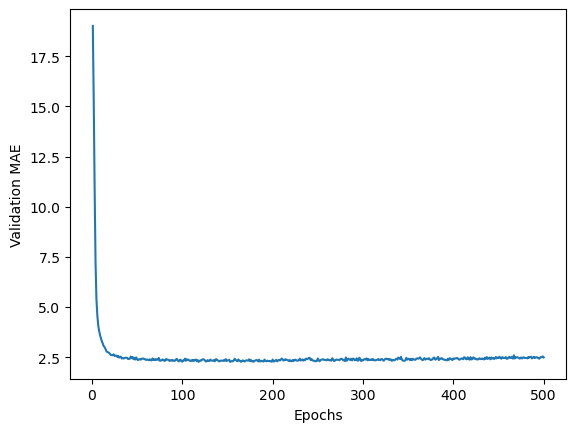

In [15]:
# 검증 점수 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

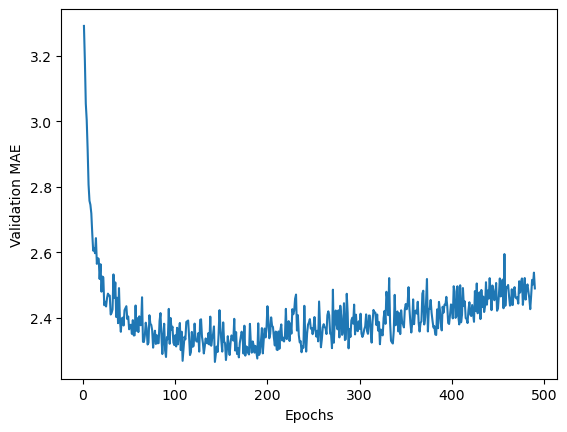

In [ ]:
# 처음 10개의 데이터 포인트를 제외한 검증 점수 그래프 그리기
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')